# **Projeto da Monografia**

Tema: Comparação de desempenho entre MobileNet treinada como Autoencoder e treinada normalmente.

In [1]:
import os
import random
import json
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from PIL import Image
import matplotlib.cm as cm

import cv2

import tensorflow as tf
import keras
from tensorflow import GradientTape
from tensorflow.keras import mixed_precision, layers, Sequential
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers.experimental import preprocessing
from keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, Concatenate, Conv2DTranspose, BatchNormalization, Dropout, Activation
from tensorflow.keras.models import Model

import warnings
warnings.filterwarnings("ignore")

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# Walking through directories
for dirpath, dirnames, filenames in os.walk("SiDi_BreakHis400x_Balanceado/train_set/"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
print('\n')
for dirpath, dirnames, filenames in os.walk("SiDi_BreakHis400x_Balanceado/validation_set/"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'SiDi_BreakHis400x_Balanceado/train_set/'.
There are 0 directories and 1037 images in 'SiDi_BreakHis400x_Balanceado/train_set/benign'.
There are 0 directories and 1037 images in 'SiDi_BreakHis400x_Balanceado/train_set/malignant'.


There are 2 directories and 0 images in 'SiDi_BreakHis400x_Balanceado/validation_set/'.
There are 0 directories and 180 images in 'SiDi_BreakHis400x_Balanceado/validation_set/benign'.
There are 0 directories and 180 images in 'SiDi_BreakHis400x_Balanceado/validation_set/malignant'.


In [4]:
# loading directories
ae_dir = 'BreakHis400x_AE/'
train_dir = 'SiDi_BreakHis400x_Balanceado/train_set/'
val_dir = 'SiDi_BreakHis400x_Balanceado/validation_set/'
test_dir = 'SiDi_BreCaHAD_test/dataset/'
test_dir_ae = 'SiDi_BreCaHAD_test/dataset/malignant/'
annotated_dir = 'SiDi_BreCaHAD_test/groundTruth_display/'

In [5]:
IMG_SIZE=(128,128)
# IMG_SIZE=(160,160)

train_ae = tf.keras.preprocessing.image_dataset_from_directory(directory=ae_dir, image_size=IMG_SIZE, 
                                                                 label_mode=None, batch_size=32, seed=42, subset='training',
                                                              validation_split=0.3)
val_ae = tf.keras.preprocessing.image_dataset_from_directory(directory=ae_dir, image_size=IMG_SIZE, 
                                                               label_mode=None, batch_size=32, seed=42, subset='validation',
                                                            validation_split=0.3)
test_ae = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir_ae, image_size=IMG_SIZE,
                                                             label_mode=None, batch_size=32)

Found 1365 files belonging to 1 classes.
Using 956 files for training.
Found 1365 files belonging to 1 classes.
Using 409 files for validation.
Found 159 files belonging to 1 classes.


In [6]:
# loading data
IMG_SIZE=(128,128)
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir, image_size=IMG_SIZE, 
                                                                 label_mode='categorical', batch_size=32)
val_data = tf.keras.preprocessing.image_dataset_from_directory(directory=val_dir, image_size=IMG_SIZE, 
                                                               label_mode='categorical', batch_size=32)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir, image_size=IMG_SIZE, 
                                                               label_mode='categorical', batch_size=32)

Found 2074 files belonging to 2 classes.
Found 360 files belonging to 2 classes.
Found 159 files belonging to 2 classes.


In [7]:
class_names = train_data.class_names
class_names

['benign', 'malignant']

In [8]:
# Function to see random image
def view_random_image(target_dir):
    
    # Get a random image path
    random_image = random.sample(os.listdir(target_dir), 1)
    
    # Read in the image and plot it using matplotlib
    img = mpimg.imread(target_dir + random_image[0])
    plt.imshow(img)
    plt.title(f'{target_dir.split("/")[1]}\n{img.shape}')
    plt.axis('off');
    
    return img

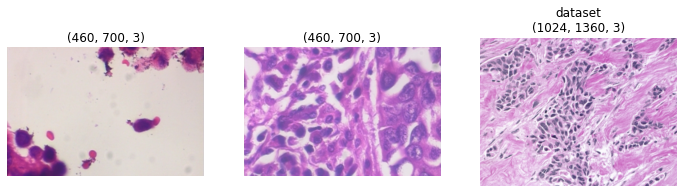

In [9]:
# view random image from training dataset
plt.figure(figsize=(12,12))

plt.subplot(1,3,1)
img1 = view_random_image('BreakHis400x_AE/')

plt.subplot(1,3,2)
img2 = view_random_image('BreakHis400x_AE/')

plt.subplot(1,3,3)
img3 = view_random_image('SiDi_BreCaHAD_test/dataset/malignant/')

## Creating Modelling Callbacks 

In [10]:
# Setup Earlystopping callback to stop training if model's val_accuracy doesn't improve for 5 epochs
ea = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta=0.001, patience=30)

# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-9)

## Setting Mixed Precision

In [11]:
# turn on mixed precision training
mixed_precision.set_global_policy('mixed_float16') # set global data policy to mixed precision

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1650, compute capability 7.5


## Batch Configuration

In [12]:
train_dt, val_dt, test_dt = [], [], []

for images in train_ae.unbatch():
    train_dt.append(images)
    
for images in val_ae.unbatch():
    val_dt.append(images)

for images in test_ae.unbatch():
    test_dt.append(images)

In [13]:
x_train = np.reshape(train_dt, (len(train_dt), 128, 128, 3))
x_val = np.reshape(val_dt, (len(val_dt), 128, 128, 3))
x_test = np.reshape(test_dt, (len(test_dt), 128, 128, 3))

In [14]:
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.

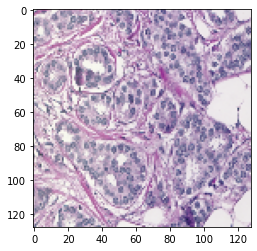

In [15]:
plt.imshow(x_test[0].astype(np.uint8))

## Building Model 

In [16]:
#Convolutional block to be used in autoencoder and U-Net
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

In [17]:
#Encoder block: Conv block followed by maxpooling
def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return p, x

In [18]:
#Decoder block for autoencoder (no skip connections)
def decoder_block(inputs, num_filters, linear=False):
    
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = conv_block(x, num_filters)
    x = conv_block(x, 1)
    x = conv_block(x, num_filters)
    x = conv_block(x, 1)
    x = conv_block(x, num_filters)
    x = conv_block(x, 1)
    x = conv_block(x, num_filters)
    x = conv_block(x, 1)
    
    return x

In [19]:
def build_encoder(input_layer, mobile_type = False):
    #inputs = Input(input_shape)
    
    if mobile_type == False:
        p1, s1 = encoder_block(input_layer, 8)
        p2, s2 = encoder_block(p1, 16)
        p3, s3 = encoder_block(p2, 32)
        p4, s4 = encoder_block(p3, 64)
        p5, s5 = encoder_block(p4, 128)

        encoded = conv_block(p5, 512, name='Bridge') #Bridge
    
    else:
#         inputs = tf.keras.layers.Input(shape=input_shape, name='input_layer')
        mobile = tf.keras.applications.MobileNetV2(include_top=False, input_tensor=input_layer, alpha=0.5,
                                                  pooling="max", weights='imagenet')
        
        # To begin fine-tuning, let's start setting the last 10 layers of our base_model.trainable = True
        mobile.trainable = True

        # Freeze again all layers except the last 10
#         for layer in mobile.layers[:-7]:
#             layer.trainable = False
        
        mobile.layers[-2]._name = 'BRIDGE'
        encoded = mobile.layers[-2].output # Bridge
    
    return encoded

In [20]:
#Decoder for Autoencoder ONLY. 
def build_decoder(encoded):
    d1 = decoder_block(encoded, 512)
    d2 = decoder_block(d1, 256)
    d3 = decoder_block(d2, 128)
    d4 = decoder_block(d3, 64)
    d5 = decoder_block(d4, 16)
    
    decoded = Conv2D(3, 3, padding="same", activation="sigmoid")(d5)
    
    return decoded

## Experiment 1: MobileNet with ImageNet Weights

In [21]:
#Use encoder and decoder blocks to build the autoencoder. 
def build_autoencoder(input_shape):
    
    input_img = tf.keras.layers.Input(shape=input_shape, name='input_layer')
#     encoder = keras.Model(input_img, build_encoder(input_img, True), name='Encoder')
#     decoder = keras.Model(encoder.output, build_decoder(encoder.output))
    autoencoder = keras.Model(input_img, build_decoder(build_encoder(input_img, True)), name='Auto_Encoder')
    
    return autoencoder

In [22]:
# input_img = keras.Input(shape=(224, 224, 3), name='input_layer')
autoencoder = build_autoencoder((128,128,3))
# encoder, autoencoder = build_autoencoder((160,160,3))
# encoder.summary()

In [23]:
autoencoder.summary()

Model: "Auto_Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 16)   432         ['input_layer[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 16)   64          ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 16)   0           ['bn_Conv1[0][0]']    

In [24]:
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy')

In [25]:
history = autoencoder.fit(x_train, x_train, epochs=70, batch_size=32, shuffle=False, validation_data=(x_val, x_val), 
                         callbacks=[reduce_lr])

Epoch 1/70
30/30 [==============================] - 71s 1s/step - loss: 0.7101 - val_loss: 0.6901 - lr: 0.0010
Epoch 2/70
30/30 [==============================] - 32s 1s/step - loss: 0.6869 - val_loss: 0.6839 - lr: 0.0010
Epoch 3/70
30/30 [==============================] - 32s 1s/step - loss: 0.6806 - val_loss: 0.6783 - lr: 0.0010
Epoch 4/70
30/30 [==============================] - 32s 1s/step - loss: 0.6751 - val_loss: 0.6735 - lr: 0.0010
Epoch 5/70
30/30 [==============================] - 32s 1s/step - loss: 0.6701 - val_loss: 0.6690 - lr: 0.0010
Epoch 6/70
30/30 [==============================] - 32s 1s/step - loss: 0.6654 - val_loss: 0.6646 - lr: 0.0010
Epoch 7/70
30/30 [==============================] - 32s 1s/step - loss: 0.6610 - val_loss: 0.6608 - lr: 0.0010
Epoch 8/70
30/30 [==============================] - 32s 1s/step - loss: 0.6569 - val_loss: 0.6570 - lr: 0.0010
Epoch 9/70
30/30 [==============================] - 32s 1s/step - loss: 0.6530 - val_loss: 0.6536 - lr: 0.0010
E

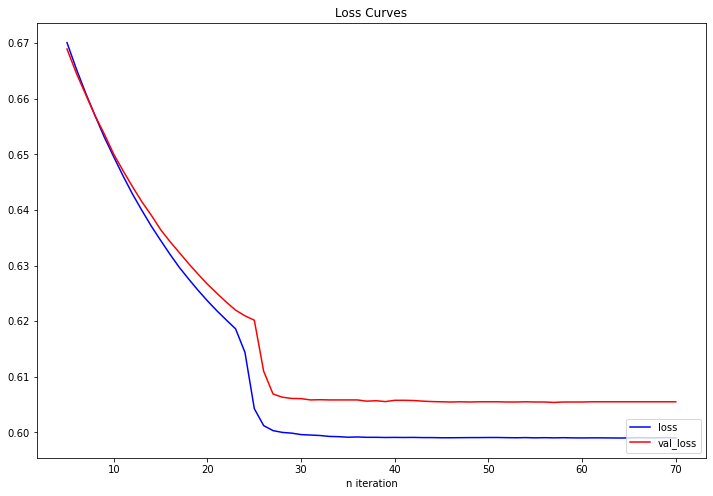

In [26]:
# Plotting Loss Curver
plt.figure(figsize=(12,8))

x_values = np.arange(1,71,1)

plt.plot(x_values[4:], history.history['loss'][4:], '-b', label='loss')
plt.plot(x_values[4:], history.history['val_loss'][4:], '-r', label='val_loss')

plt.xlabel("n iteration")
plt.legend(loc='lower right')
plt.title("Loss Curves")

# show
plt.show()

In [27]:
preds = autoencoder.predict(x_test)
pred_u8 = (preds[0]*255).astype(np.uint8)
orig_u8 = x_test[0].astype(np.uint8)

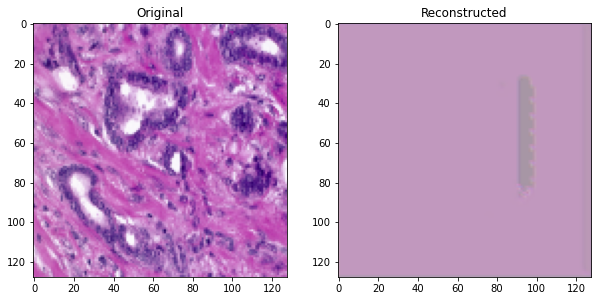

In [28]:
plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.imshow(orig_u8)
plt.title('Original')

plt.subplot(1,2,2)
plt.imshow(pred_u8)
plt.title('Reconstructed')

plt.show()

### Salvando O Modelo

In [29]:
autoencoder.save('saved_model/autoencoder_imagenet_weights')

INFO:tensorflow:Assets written to: saved_model/autoencoder_imagenet_weights\assets


## Experiment 2: MobileNet with Random Weights

In [21]:
def build_encoder_2(input_layer, mobile_type = False):
    #inputs = Input(input_shape)
    
    if mobile_type == False:
        p1, s1 = encoder_block(input_layer, 8)
        p2, s2 = encoder_block(p1, 16)
        p3, s3 = encoder_block(p2, 32)
        p4, s4 = encoder_block(p3, 64)
        p5, s5 = encoder_block(p4, 128)

        encoded = conv_block(p5, 512) #Bridge
    
    else:
#         inputs = tf.keras.layers.Input(shape=input_shape, name='input_layer')
        mobile = tf.keras.applications.MobileNetV2(include_top=False, input_tensor=input_layer, alpha=0.5,
                                                  pooling="max", weights=None)
        
        # To begin fine-tuning, let's start setting the last 10 layers of our base_model.trainable = True
        mobile.trainable = True

        # Freeze again all layers except the last 10
#         for layer in mobile.layers[:-7]:
#             layer.trainable = False
        
        mobile.layers[-2]._name = 'BRIDGE'
        encoded = mobile.layers[-2].output # Bridge
    
    return encoded

In [22]:
def build_autoencoder_2(input_shape):
    
    input_img = tf.keras.layers.Input(shape=input_shape, name='input_layer')
    encoder = keras.Model(input_img, build_encoder_2(input_img, True), name='Encoder_Random')
    decoder = keras.Model(encoder.output, build_decoder(encoder.output))
    autoencoder = keras.Model(input_img, build_decoder(build_encoder_2(input_img, True)), name='Auto_Encoder_Random')
    
    return encoder, autoencoder

In [23]:
# input_img = keras.Input(shape=(224, 224, 3), name='input_layer')
encoder_2, autoencoder_2 = build_autoencoder_2((128,128,3))
# encoder, autoencoder = build_autoencoder((160,160,3))
encoder_2.summary()

Model: "Encoder_Random"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 16)   432         ['input_layer[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 16)   64          ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 16)   0           ['bn_Conv1[0][0]']  

In [24]:
autoencoder_2.summary()

Model: "Auto_Encoder_Random"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 16)   432         ['input_layer[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 16)   64          ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 16)   0           ['bn_Conv1[0][0

In [25]:
autoencoder_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy')

In [26]:
history_2 = autoencoder_2.fit(x_train, x_train, epochs=70, batch_size=32, shuffle=False, validation_data=(x_val, x_val),  
                         callbacks=[reduce_lr])

Epoch 1/70
30/30 [==============================] - 75s 1s/step - loss: 0.6862 - val_loss: 0.6902 - lr: 0.0010
Epoch 2/70
30/30 [==============================] - 32s 1s/step - loss: 0.6536 - val_loss: 0.6839 - lr: 0.0010
Epoch 3/70
30/30 [==============================] - 32s 1s/step - loss: 0.6279 - val_loss: 0.6681 - lr: 0.0010
Epoch 4/70
30/30 [==============================] - 32s 1s/step - loss: 0.6134 - val_loss: 0.6425 - lr: 0.0010
Epoch 5/70
30/30 [==============================] - 32s 1s/step - loss: 0.6056 - val_loss: 0.6299 - lr: 0.0010
Epoch 6/70
30/30 [==============================] - 32s 1s/step - loss: 0.6019 - val_loss: 0.6128 - lr: 0.0010
Epoch 7/70
30/30 [==============================] - 32s 1s/step - loss: 0.6003 - val_loss: 0.6071 - lr: 0.0010
Epoch 8/70
30/30 [==============================] - 32s 1s/step - loss: 0.5997 - val_loss: 0.6060 - lr: 0.0010
Epoch 9/70
30/30 [==============================] - 32s 1s/step - loss: 0.5997 - val_loss: 0.6057 - lr: 0.0010
E

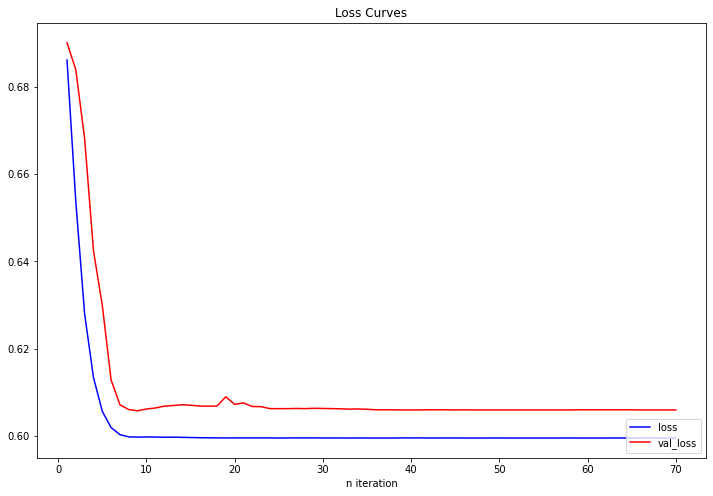

In [30]:
# Plotting Loss Curver
plt.figure(figsize=(12,8))

x_values = np.arange(1,71,1)

plt.plot(x_values, history_2.history['loss'], '-b', label='loss')
plt.plot(x_values, history_2.history['val_loss'], '-r', label='val_loss')

plt.xlabel("n iteration")
plt.legend(loc='lower right')
plt.title("Loss Curves")

# show
plt.show()

In [37]:
preds2 = autoencoder_2.predict(x_test)
pred2_u8 = (preds2[0]*255).astype(np.uint8)
orig2_u8 = x_test[0].astype(np.uint8)

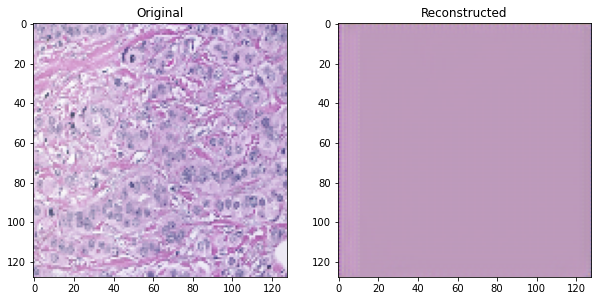

In [38]:
plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.imshow(orig2_u8)
plt.title('Original')

plt.subplot(1,2,2)
plt.imshow(pred2_u8)
plt.title('Reconstructed')

plt.show()

### Salvando O Modelo

In [39]:
autoencoder_2.save('saved_model/autoencoder_random_weights')

INFO:tensorflow:Assets written to: saved_model/autoencoder_random_weights\assets


## Adding MLPs to Classification

In [20]:
from helper_functions import make_confusion_matrix, plot_loss_curves

In [21]:
# true labels
test_labels = []
for _, label in test_data.unbatch():
    test_labels.append(label)
y_true = np.ones((159,), dtype='int8')

### MobileNet Vanilla

In [42]:
# Create Base Model
input_shape = (128,128,3)

# Create Functional Model

inputs = layers.Input(shape=input_shape, name='input_layer')
base_mob = tf.keras.applications.MobileNetV2(include_top=False, input_tensor=inputs,
                                            alpha=0.5, weights='imagenet')
base_mob.trainable = False
x = layers.GlobalAveragePooling2D()(base_mob.output)
x = layers.BatchNormalization()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(16, activation='relu')(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(2, activation='softmax', dtype = tf.float32, name='softmax_float_32')(x)
model_vanilla = tf.keras.Model(inputs, outputs, name='MobileNet_Vanilla')

# compiling the model
model_vanilla.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [43]:
model_vanilla.summary()

Model: "MobileNet_Vanilla"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 16)   432         ['input_layer[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 16)   64          ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 16)   0           ['bn_Conv1[0][0]'

In [44]:
# Fitting the model

history_base = model_vanilla.fit(train_data, epochs=100, steps_per_epoch=len(train_data), validation_data=val_data, validation_steps=len(val_data), 
                                 callbacks=[reduce_lr, ea])

Epoch 1/100
65/65 [==============================] - 9s 88ms/step - loss: 0.6257 - accuracy: 0.7353 - val_loss: 0.7453 - val_accuracy: 0.6028 - lr: 0.0010
Epoch 2/100
65/65 [==============================] - 5s 72ms/step - loss: 0.3614 - accuracy: 0.8462 - val_loss: 0.5925 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 3/100
65/65 [==============================] - 5s 71ms/step - loss: 0.3320 - accuracy: 0.8529 - val_loss: 0.5224 - val_accuracy: 0.7750 - lr: 0.0010
Epoch 4/100
65/65 [==============================] - 5s 71ms/step - loss: 0.3025 - accuracy: 0.8669 - val_loss: 0.5246 - val_accuracy: 0.7528 - lr: 0.0010
Epoch 5/100
65/65 [==============================] - 5s 72ms/step - loss: 0.2692 - accuracy: 0.8857 - val_loss: 0.5051 - val_accuracy: 0.7861 - lr: 0.0010
Epoch 6/100
65/65 [==============================] - 5s 71ms/step - loss: 0.2804 - accuracy: 0.8766 - val_loss: 0.5218 - val_accuracy: 0.7750 - lr: 0.0010
Epoch 7/100
65/65 [==============================] - 5s 72ms/step - lo

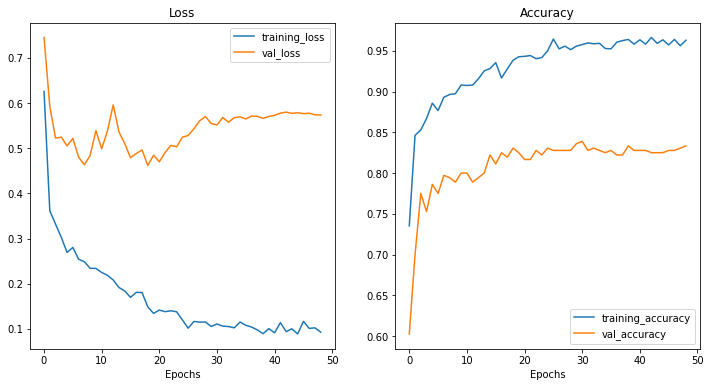

In [50]:
# plotting loss curves
plot_loss_curves(history_base)

In [51]:
model_vanilla.evaluate(test_data)

5/5 [==============================] - 2s 40ms/step - loss: 0.7382 - accuracy: 0.7044


[0.7382471561431885, 0.704402506351471]

In [52]:
model_vanilla_preds_probs = model_vanilla.predict(test_data)

In [53]:
model_vanilla_preds = tf.argmax(model_vanilla_preds_probs, axis=1)

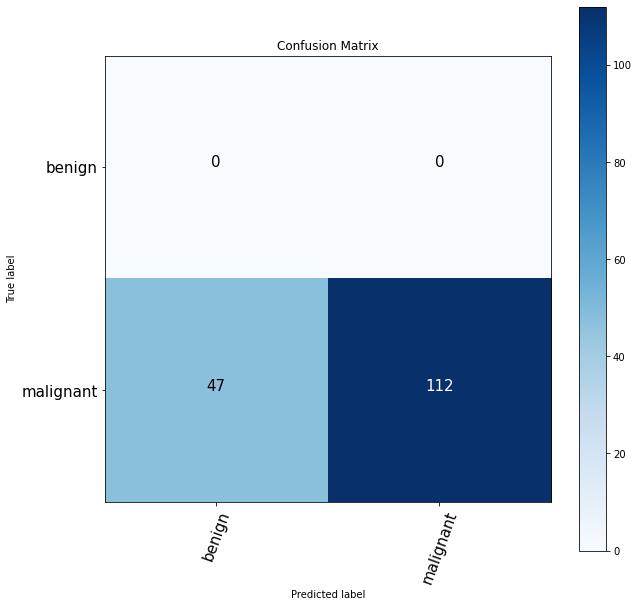

In [54]:
make_confusion_matrix(y_true, model_vanilla_preds, test_data.class_names)

In [55]:
# saving vanilla model

model_vanilla.save('saved_model/models/mobile_vanilla')

INFO:tensorflow:Assets written to: saved_model/models/mobile_vanilla\assets


In [23]:
loaded_vanilla = tf.keras.models.load_model('saved_model/models/mobile_vanilla/')

### MobileNet Encoded with Random Weights

In [76]:
# loading and setting the random weights encoder
encoder_random = tf.keras.models.load_model('saved_model/autoencoder_random_weights/')

# base model
mobile_re = tf.keras.Model(encoder_random.input, encoder_random.get_layer('BRIDGE').output, name='Encoder_Random')
mobile_re.trainable = False

mobile_re.summary()

Model: "Encoder_Random"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 16)   432         ['input_layer[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 16)   64          ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 16)   0           ['bn_Conv1[0][0]']  

In [86]:
# adding the mlp top
# Create Base Model
input_shape = (128,128,3)

# Create Functional Model

x = layers.GlobalAveragePooling2D()(mobile_re.output)
x = layers.BatchNormalization()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.1)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.1)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(16, activation='relu')(x)
x = layers.Dropout(0.1)(x)

outputs = layers.Dense(2, activation='softmax', dtype = tf.float32, name='softmax_float_32')(x)

# Random weights model
model_mrw = tf.keras.Model(mobile_re.input, outputs, name='MobileNet_Random_Weights')

# compiling the model
model_mrw.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [87]:
model_mrw.summary()

Model: "MobileNet_Random_Weights"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 16)   432         ['input_layer[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 16)   64          ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 16)   0           ['bn_Conv1

In [88]:
# Fitting the model

history_mrw = model_mrw.fit(train_data, epochs=100, steps_per_epoch=len(train_data), validation_data=val_data, validation_steps=len(val_data), 
                                 callbacks=[reduce_lr, ea])

Epoch 1/100
65/65 [==============================] - 11s 96ms/step - loss: 0.7776 - accuracy: 0.4841 - val_loss: 0.6942 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/100
65/65 [==============================] - 5s 74ms/step - loss: 0.7244 - accuracy: 0.5087 - val_loss: 0.6935 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/100
65/65 [==============================] - 6s 91ms/step - loss: 0.7214 - accuracy: 0.4947 - val_loss: 0.6935 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/100
65/65 [==============================] - 7s 95ms/step - loss: 0.6969 - accuracy: 0.5395 - val_loss: 0.6938 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/100
65/65 [==============================] - 7s 94ms/step - loss: 0.6847 - accuracy: 0.5593 - val_loss: 0.6933 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 6/100
65/65 [==============================] - 6s 91ms/step - loss: 0.6435 - accuracy: 0.6225 - val_loss: 0.6998 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 7/100
65/65 [==============================] - 6s 89ms/step - l

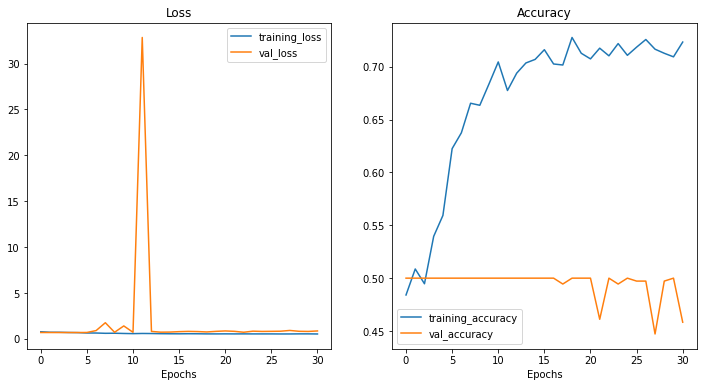

In [89]:
# plotting loss curves
plot_loss_curves(history_mrw)

In [90]:
model_mrw.evaluate(test_data)

5/5 [==============================] - 2s 42ms/step - loss: 0.8797 - accuracy: 0.6352


[0.8797459602355957, 0.6352201104164124]

In [91]:
model_mrw_preds_probs = model_mrw.predict(test_data)

In [92]:
model_mrw_preds = tf.argmax(model_mrw_preds_probs, axis=1)

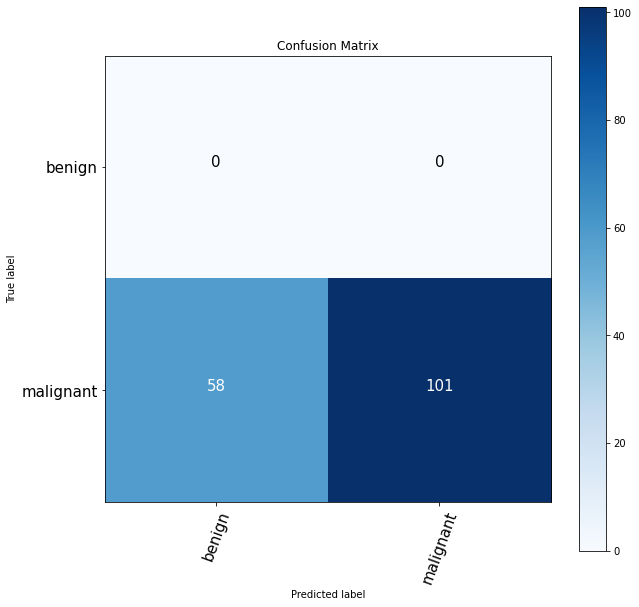

In [93]:
make_confusion_matrix(y_true, model_mrw_preds, test_data.class_names)

In [94]:
# saving vanilla model

model_mrw.save('saved_model/models/mobile_rand_weights')

INFO:tensorflow:Assets written to: saved_model/models/mobile_rand_weights\assets


In [22]:
loaded_mrw = tf.keras.models.load_model('saved_model/models/mobile_rand_weights')

### MobileNet Encoded with ImageNet Weights

In [67]:
# loading and setting the random weights encoder
encoder_imagenet = tf.keras.models.load_model('saved_model/autoencoder_imagenet_weights/')

# base model
mobile_ie = tf.keras.Model(encoder_imagenet.input, encoder_imagenet.get_layer('BRIDGE').output, name='Encoder_ImageNet')
mobile_ie.trainable = True

mobile_ie.summary()

Model: "Encoder_ImageNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 16)   432         ['input_layer[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 16)   64          ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 16)   0           ['bn_Conv1[0][0]']

In [68]:
# adding the mlp top
# Create Base Model
input_shape = (128,128,3)

# Create Functional Model

x = layers.GlobalAveragePooling2D()(mobile_ie.output)
x = layers.BatchNormalization()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(16, activation='relu')(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(2, activation='softmax', dtype = tf.float32, name='softmax_float_32')(x)

# Random weights model
model_miw = tf.keras.Model(mobile_ie.input, outputs, name='MobileNet_ImageNet_Weights')

# compiling the model
model_miw.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [69]:
model_miw.summary()

Model: "MobileNet_ImageNet_Weights"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 16)   432         ['input_layer[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 16)   64          ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 16)   0           ['bn_Con

In [70]:
# Fitting the model
history_miw = model_miw.fit(train_data, epochs=100, steps_per_epoch=len(train_data), validation_data=val_data, validation_steps=len(val_data), 
                                 callbacks=[reduce_lr, ea])

Epoch 1/100
65/65 [==============================] - 18s 163ms/step - loss: 0.6270 - accuracy: 0.7199 - val_loss: 3.9883 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/100
65/65 [==============================] - 10s 145ms/step - loss: 0.3444 - accuracy: 0.8428 - val_loss: 4.1769 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/100
65/65 [==============================] - 10s 155ms/step - loss: 0.2565 - accuracy: 0.8867 - val_loss: 6.7409 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/100
65/65 [==============================] - 11s 156ms/step - loss: 0.2161 - accuracy: 0.9113 - val_loss: 8.3235 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/100
65/65 [==============================] - 11s 155ms/step - loss: 0.1835 - accuracy: 0.9209 - val_loss: 5.5615 - val_accuracy: 0.5222 - lr: 0.0010
Epoch 6/100
65/65 [==============================] - 10s 144ms/step - loss: 0.1765 - accuracy: 0.9378 - val_loss: 2.1231 - val_accuracy: 0.6333 - lr: 0.0010
Epoch 7/100
65/65 [==============================] - 10s 1

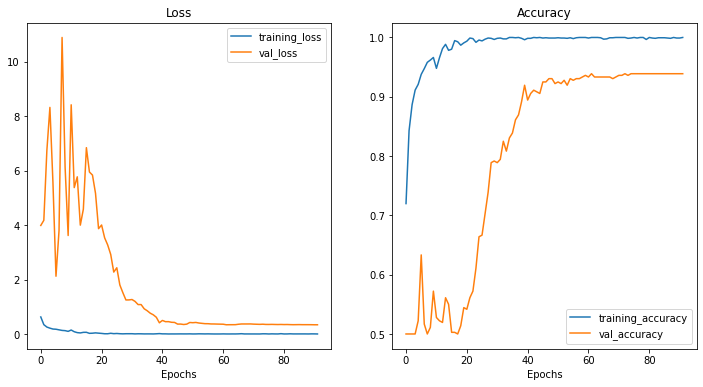

In [71]:
# plotting loss curves
plot_loss_curves(history_miw)

In [72]:
model_miw.evaluate(test_data)

5/5 [==============================] - 3s 51ms/step - loss: 1.4762 - accuracy: 0.7862


[1.4761837720870972, 0.7861635088920593]

In [73]:
model_miw_preds_probs = model_miw.predict(test_data)

In [74]:
model_miw_preds = tf.argmax(model_miw_preds_probs, axis=1)

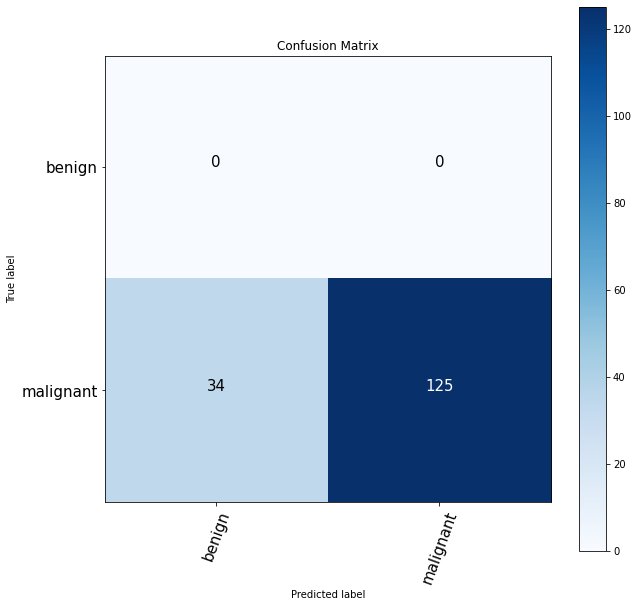

In [75]:
make_confusion_matrix(y_true, model_miw_preds, test_data.class_names)

In [95]:
# saving vanilla model

model_miw.save('saved_model/models/mobile_imagenet_weights')

INFO:tensorflow:Assets written to: saved_model/models/mobile_imagenet_weights\assets


In [24]:
loaded_miw = tf.keras.models.load_model('saved_model/models/mobile_imagenet_weights/')

## Interpretability of the Models

In [96]:
import interpretability_data as it

In [97]:
# Generating Dataframes

df_vanilla = it.generating_dataset(model_vanilla, 'BreCaHAD_test_png/', 'SiDi_BreCaHAD_test/groundTruth/', class_names)
df_mrw = it.generating_dataset(model_mrw, 'BreCaHAD_test_png/', 'SiDi_BreCaHAD_test/groundTruth/', class_names)
df_miw = it.generating_dataset(model_miw, 'BreCaHAD_test_png/', 'SiDi_BreCaHAD_test/groundTruth/', class_names)

In [177]:
df_vanilla.head()

Case Total Tumor Cells Pred. Type Probability (%) Tumors Found  \
0  Case_1-01               140  malignant           76.98           71   
1  Case_1-02               153  malignant           99.71           64   
2  Case_1-03               135  malignant           79.31          135   
3  Case_1-04               103  malignant           92.32           74   
4  Case_1-05               126  malignant           84.02           48   

  Interpret. Region Accuracy (%)  
0                          50.71  
1                          41.83  
2                          100.0  
3                          71.84  
4                           38.1

In [99]:
df_mrw.head()

Case Total Tumor Cells Pred. Type Probability (%) Tumors Found  \
0  Case_1-01               140     benign            68.3          124   
1  Case_1-02               153     benign           75.33          152   
2  Case_1-03               135  malignant           70.78           34   
3  Case_1-04               103  malignant           60.28           24   
4  Case_1-05               126     benign           55.48          117   

  Interpret. Region Accuracy (%)  
0                              0  
1                              0  
2                          25.19  
3                           23.3  
4                              0

In [200]:
df_miw.head()

Case Total Tumor Cells Pred. Type Probability (%) Tumors Found  \
0  Case_1-01               140     benign           100.0           89   
1  Case_1-02               153     benign           55.75          121   
2  Case_1-03               135     benign           99.84           68   
3  Case_1-04               103  malignant           99.65           55   
4  Case_1-05               126     benign           99.95           46   

  Interpret. Region Accuracy (%)  
0                              0  
1                              0  
2                              0  
3                           53.4  
4                              0

### Models Metrics

#### Vanilla 

In [101]:
# Interpretability

mean_vanilla = df_vanilla[df_vanilla['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].mean()
stdd_vanilla = df_vanilla[df_vanilla['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].std()
summ_total_vanilla = df_vanilla[df_vanilla['Pred. Type'] == 'malignant']['Total Tumor Cells'].sum()
summ_ind_vanilla = df_vanilla[df_vanilla['Pred. Type'] == 'malignant']['Tumors Found'].sum()
median_vanilla = df_vanilla[df_vanilla['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].median()
max_v_vanilla = df_vanilla[df_vanilla['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].max()
min_v_vanilla = df_vanilla[df_vanilla['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].min()
itp_model_vanilla = round(mean_vanilla, 2)
std_deviation_vanilla = round(stdd_vanilla, 2)
median_model_vanilla = round(median_vanilla, 2)

print(f'Model Average Interpretability: {itp_model_vanilla} +/- {std_deviation_vanilla}. With Median: {median_model_vanilla}')
print(f'\nMin.: {min_v_vanilla} | Max.: {max_v_vanilla}')

Model Average Interpretability: 58.48 +/- 20.78. With Median: 57.89

Min.: 2.22 | Max.: 100.0


In [102]:
# Model Accuracy

model_acc_vanilla = len(df_vanilla[df_vanilla['Pred. Type'] == 'malignant'])/159

print(f'Model Accuracy (%): {round(model_acc_vanilla*100, 2)}')

Model Accuracy (%): 72.33


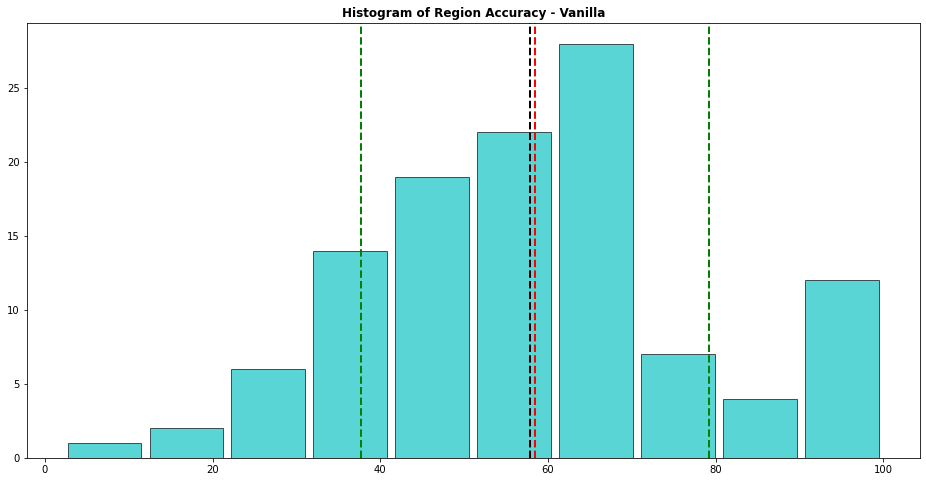

In [103]:
plt.figure(figsize=(16,8))
values_vanilla = df_vanilla[df_vanilla['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)']
plt.hist(x=values_vanilla, bins=10, color='c', edgecolor='k', alpha=0.65, rwidth=0.9)
plt.axvline(values_vanilla.median(), color='k', linestyle='dashed', linewidth=2)
plt.axvline(values_vanilla.mean(), color='red', linestyle='dashed', linewidth=2)
plt.axvline(values_vanilla.mean() + values_vanilla.std(), color='green', linestyle='dashed', linewidth=2)
plt.axvline(values_vanilla.mean() - values_vanilla.std(), color='green', linestyle='dashed', linewidth=2)
plt.title('Histogram of Region Accuracy - Vanilla', fontweight='bold');

#### With Random Weights

In [104]:
# Interpretability

mean_mrw = df_mrw[df_mrw['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].mean()
stdd_mrw = df_mrw[df_mrw['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].std()
summ_total_mrw = df_mrw[df_mrw['Pred. Type'] == 'malignant']['Total Tumor Cells'].sum()
summ_ind_mrw = df_mrw[df_mrw['Pred. Type'] == 'malignant']['Tumors Found'].sum()
median_mrw = df_mrw[df_mrw['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].median()
max_v_mrw = df_mrw[df_mrw['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].max()
min_v_mrw = df_mrw[df_mrw['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].min()
itp_model_mrw = round(mean_mrw, 2)
std_deviation_mrw = round(stdd_mrw, 2)
median_model_mrw = round(median_mrw, 2)

print(f'Model Average Interpretability: {itp_model_mrw} +/- {std_deviation_mrw}. With Median: {median_model_mrw}')
print(f'\nMin.: {min_v_mrw} | Max.: {max_v_mrw}')

Model Average Interpretability: 22.15 +/- 9.03. With Median: 22.5

Min.: 0.0 | Max.: 48.15


In [105]:
# Model Accuracy

model_acc_mrw = len(df_mrw[df_mrw['Pred. Type'] == 'malignant'])/159

print(f'Model Accuracy (%): {round(model_acc_mrw*100, 2)}')

Model Accuracy (%): 56.6


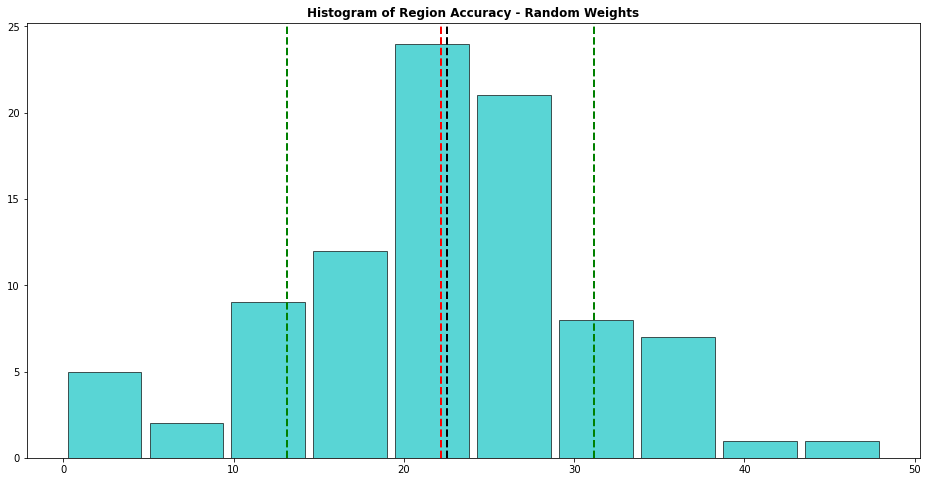

In [106]:
plt.figure(figsize=(16,8))
values_mrw = df_mrw[df_mrw['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)']
plt.hist(x=values_mrw, bins=10, color='c', edgecolor='k', alpha=0.65, rwidth=0.9)
plt.axvline(values_mrw.median(), color='k', linestyle='dashed', linewidth=2)
plt.axvline(values_mrw.mean(), color='red', linestyle='dashed', linewidth=2)
plt.axvline(values_mrw.mean() + values_mrw.std(), color='green', linestyle='dashed', linewidth=2)
plt.axvline(values_mrw.mean() - values_mrw.std(), color='green', linestyle='dashed', linewidth=2)
plt.title('Histogram of Region Accuracy - Random Weights', fontweight='bold');

#### With ImageNet Weights

In [107]:
# Interpretability

mean_miw = df_miw[df_miw['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].mean()
stdd_miw = df_miw[df_miw['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].std()
summ_total_miw = df_miw[df_miw['Pred. Type'] == 'malignant']['Total Tumor Cells'].sum()
summ_ind_miw = df_miw[df_miw['Pred. Type'] == 'malignant']['Tumors Found'].sum()
median_miw = df_miw[df_miw['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].median()
max_v_miw = df_miw[df_miw['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].max()
min_v_miw = df_miw[df_miw['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].min()
itp_model_miw = round(mean_miw, 2)
std_deviation_miw = round(stdd_miw, 2)
median_model_miw = round(median_miw, 2)

print(f'Model Average Interpretability: {itp_model_miw} +/- {std_deviation_miw}. With Median: {median_model_miw}')
print(f'\nMin.: {min_v_miw} | Max.: {max_v_miw}')

Model Average Interpretability: 48.53 +/- 20.25. With Median: 47.1

Min.: 0.0 | Max.: 100.0


In [108]:
# Model Accuracy

model_acc_miw = len(df_miw[df_miw['Pred. Type'] == 'malignant'])/159

print(f'Model Accuracy (%): {round(model_acc_miw*100, 2)}')

Model Accuracy (%): 76.73


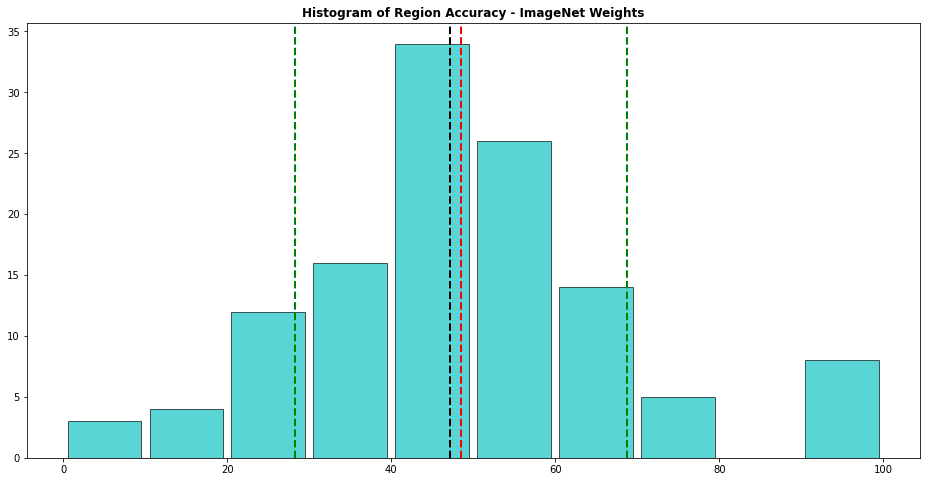

In [109]:
plt.figure(figsize=(16,8))
values_miw = df_miw[df_miw['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)']
plt.hist(x=values_miw, bins=10, color='c', edgecolor='k', alpha=0.65, rwidth=0.9)
plt.axvline(values_miw.median(), color='k', linestyle='dashed', linewidth=2)
plt.axvline(values_miw.mean(), color='red', linestyle='dashed', linewidth=2)
plt.axvline(values_miw.mean() + values_miw.std(), color='green', linestyle='dashed', linewidth=2)
plt.axvline(values_miw.mean() - values_miw.std(), color='green', linestyle='dashed', linewidth=2)
plt.title('Histogram of Region Accuracy - ImageNet Weights', fontweight='bold');

# **TEST AREA**

In [25]:
import interpretability_tester as it_test

[[0.10425 0.1914  0.5015  0.515  ]
 [0.2915  0.5376  0.7617  0.717  ]
 [0.5747  0.783   1.      0.8506 ]
 [0.4905  0.6875  0.8535  0.589  ]]


<Figure size 720x360 with 0 Axes>

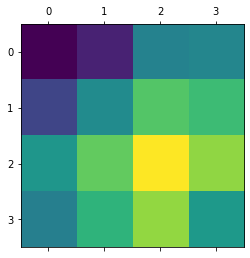

[[0.2324 0.5947 0.304  0.3118]
 [0.4592 1.     0.5054 0.291 ]
 [0.404  0.866  0.392  0.1068]
 [0.2559 0.3123 0.     0.    ]]


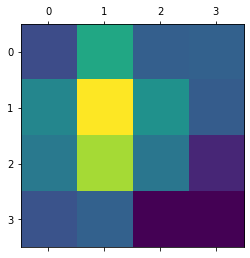

[[1.     0.1617 0.2576 0.    ]
 [0.3196 0.     0.     0.    ]
 [0.2817 0.     0.0514 0.    ]
 [0.     0.     0.     0.    ]]


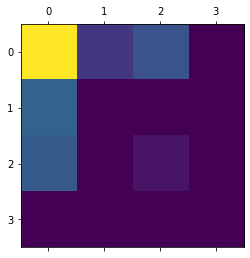

In [27]:
plt.figure(figsize=(10,5))


PATH1 = 'SiDi_BreCaHAD_test/groundTruth_display/Case_13-07.png'
IMG1 = 'BreCaHAD_test_png/Case_13-07.png'
img1 = tf.keras.utils.load_img(PATH1)
img_orig = tf.keras.utils.load_img(IMG1)
# heatmap1, class_1, probs1 = it_test.generate_heatmap(IMG1, model_miw, class_names)
# heatmap2, class_2, probs2 = it_test.generate_heatmap(IMG1, model_vanilla, class_names)
# heatmap3, class_3, probs3 = it_test.generate_heatmap(IMG1, model_mrw, class_names)
heatmap1, class_1, probs1 = it_test.generate_heatmap(IMG1, loaded_miw, class_names)
heatmap2, class_2, probs2 = it_test.generate_heatmap(IMG1, loaded_vanilla, class_names)
heatmap3, class_3, probs3 = it_test.generate_heatmap(IMG1, loaded_mrw, class_names)


# PATH2 = 'SiDi_BreCaHAD_test/groundTruth_display/Case_4-07.png'
# IMG2 = 'BreCaHAD_test_png/Case_4-07.png'
# img2 = tf.keras.utils.load_img(PATH2)
# img_orig_2 = tf.keras.utils.load_img(IMG2)
# heatmap2, class_2, probs2 = it_test.generate_heatmap(IMG2, model_miw, class_names)

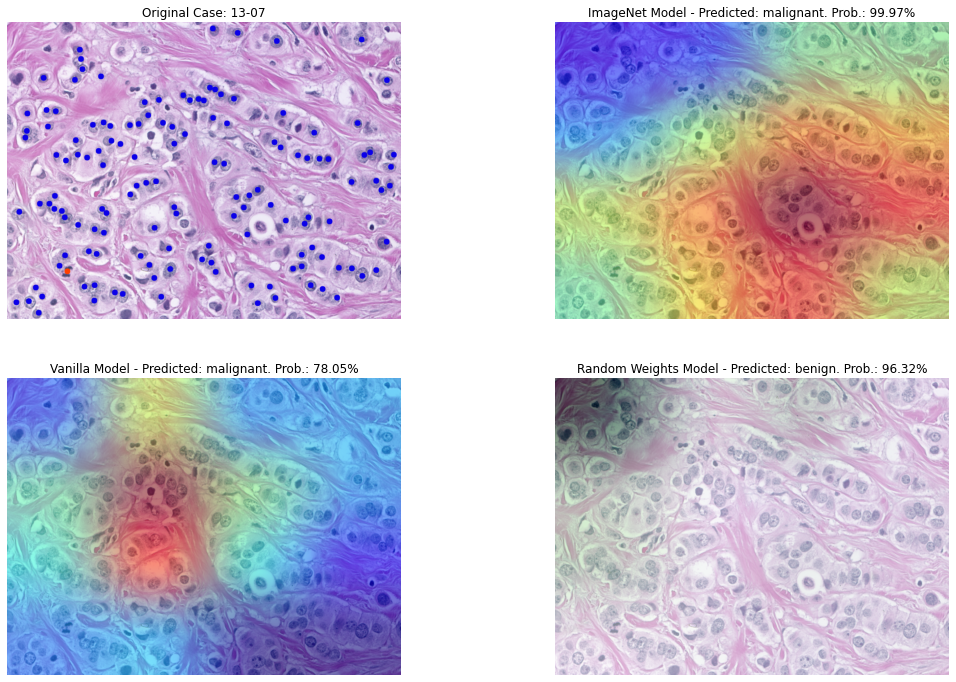

In [28]:
plt.figure(figsize=(18,12))

plt.subplot(2,2,1)
plt.title(f'Original Case: 13-07')
plt.axis(False)
plt.imshow(img1)
plt.subplot(2,2,2)
plt.title(f'ImageNet Model - Predicted: {class_1}. Prob.: {round(probs1*100,2)}%')
plt.axis(False)
result1 = it_test.save_and_display_gradcam(img_path=IMG1, heatmap=heatmap1, pred=class_1)
plt.subplot(2,2,3)
plt.title(f'Vanilla Model - Predicted: {class_2}. Prob.: {round(probs2*100,2)}%')
plt.axis(False)
result2 = it_test.save_and_display_gradcam(img_path=IMG1, heatmap=heatmap2, pred=class_2)
plt.subplot(2,2,4)
plt.title(f'Random Weights Model - Predicted: {class_3}. Prob.: {round(probs3*100,2)}%')
plt.axis(False)
result3 = it_test.save_and_display_gradcam(img_path=IMG1, heatmap=heatmap3, pred=class_3);

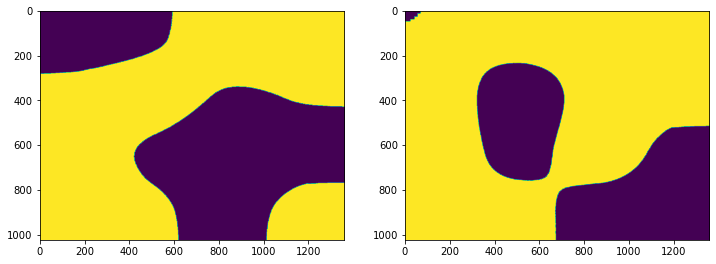

In [34]:
plt.figure(figsize=(12,10))

plt.subplot(1,2,1)
plt.imshow(result1)
plt.subplot(1,2,2)
plt.imshow(result2)

[[0.3052 0.5684 0.4106 0.337 ]
 [0.479  0.8633 0.5317 0.5894]
 [0.5894 1.     0.6895 0.758 ]
 [0.4685 0.9106 0.726  0.7   ]]


<Figure size 720x360 with 0 Axes>

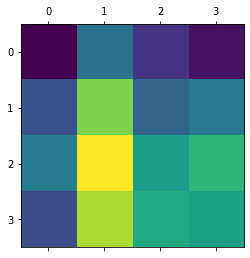

[[0.213  0.634  0.765  0.491 ]
 [0.4739 0.5923 0.705  0.8994]
 [0.4106 0.5767 0.7485 0.9927]
 [0.2744 0.664  1.     0.682 ]]


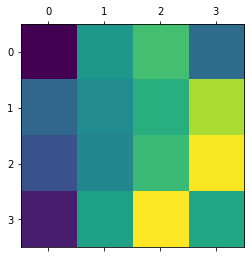

[[0.      0.      0.      0.1678 ]
 [0.      0.0455  0.0643  0.3777 ]
 [0.      0.04065 0.      0.279  ]
 [0.712   1.      0.8945  0.3223 ]]


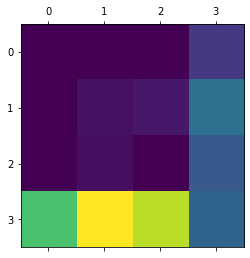

In [32]:
plt.figure(figsize=(10,5))


PATH1 = 'SiDi_BreCaHAD_test/groundTruth_display/Case_4-07.png'
IMG1 = 'BreCaHAD_test_png/Case_4-07.png'
img1 = tf.keras.utils.load_img(PATH1)
img_orig = tf.keras.utils.load_img(IMG1)
# heatmap1, class_1, probs1 = it_test.generate_heatmap(IMG1, model_miw, class_names)
# heatmap2, class_2, probs2 = it_test.generate_heatmap(IMG1, model_vanilla, class_names)
# heatmap3, class_3, probs3 = it_test.generate_heatmap(IMG1, model_mrw, class_names)
heatmap1, class_1, probs1 = it_test.generate_heatmap(IMG1, loaded_miw, class_names)
heatmap2, class_2, probs2 = it_test.generate_heatmap(IMG1, loaded_vanilla, class_names)
heatmap3, class_3, probs3 = it_test.generate_heatmap(IMG1, loaded_mrw, class_names)


# PATH2 = 'SiDi_BreCaHAD_test/groundTruth_display/Case_4-07.png'
# IMG2 = 'BreCaHAD_test_png/Case_4-07.png'
# img2 = tf.keras.utils.load_img(PATH2)
# img_orig_2 = tf.keras.utils.load_img(IMG2)
# heatmap2, class_2, probs2 = it_test.generate_heatmap(IMG2, model_miw, class_names)

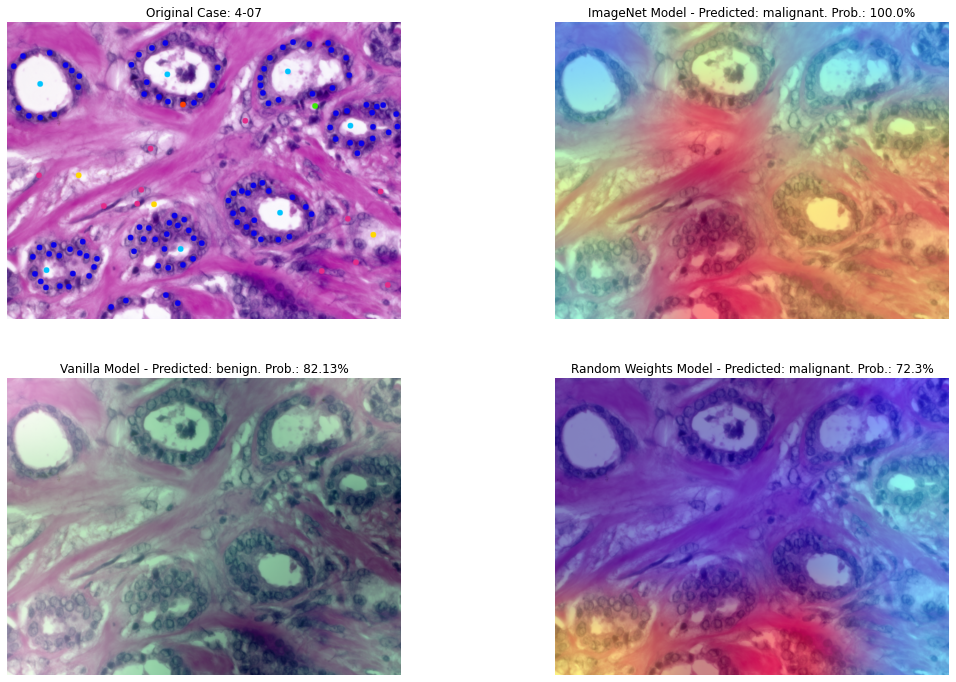

In [35]:
plt.figure(figsize=(18,12))

plt.subplot(2,2,1)
plt.title(f'Original Case: 4-07')
plt.axis(False)
plt.imshow(img1)
plt.subplot(2,2,2)
plt.title(f'ImageNet Model - Predicted: {class_1}. Prob.: {round(probs1*100,2)}%')
plt.axis(False)
result_alpha = it_test.save_and_display_gradcam(img_path=IMG1, heatmap=heatmap1, pred=class_1)
plt.subplot(2,2,3)
plt.title(f'Vanilla Model - Predicted: {class_2}. Prob.: {round(probs2*100,2)}%')
plt.axis(False)
result_beta = it_test.save_and_display_gradcam(img_path=IMG1, heatmap=heatmap2, pred=class_2)
plt.subplot(2,2,4)
plt.title(f'Random Weights Model - Predicted: {class_3}. Prob.: {round(probs3*100,2)}%')
plt.axis(False)
it_test.save_and_display_gradcam(img_path=IMG1, heatmap=heatmap3, pred=class_3);

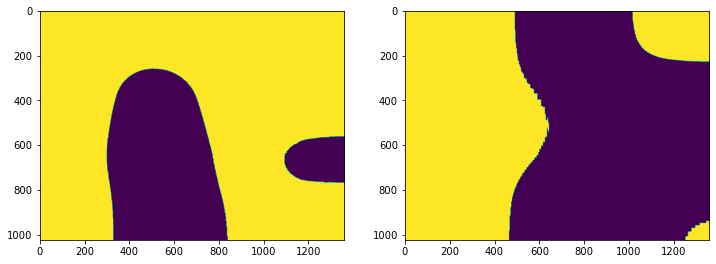

In [36]:
plt.figure(figsize=(12,10))

plt.subplot(1,2,1)
plt.imshow(result_alpha)
plt.subplot(1,2,2)
plt.imshow(result_beta)

[[0.     0.2502 0.512  0.661 ]
 [0.1735 0.6694 0.8794 1.    ]
 [0.3345 0.6196 0.639  0.7397]
 [0.4329 0.64   0.656  0.623 ]]


<Figure size 720x360 with 0 Axes>

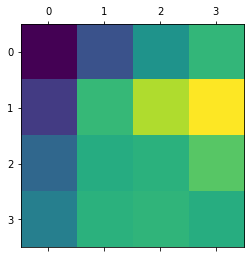

[[0.03162 0.4082  0.      0.2052 ]
 [0.3613  0.93    0.3838  0.3938 ]
 [0.498   1.      0.3918  0.3118 ]
 [0.3743  0.623   0.3274  0.2134 ]]


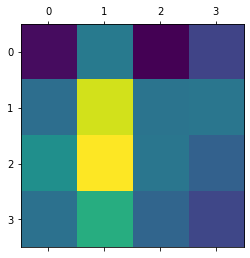

[[0.      0.      0.      0.1643 ]
 [0.      0.05017 0.06866 0.3777 ]
 [0.      0.0416  0.      0.2761 ]
 [0.7095  1.      0.892   0.322  ]]


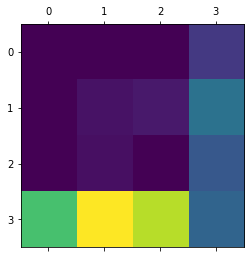

In [29]:
plt.figure(figsize=(10,5))


PATH1 = 'SiDi_BreCaHAD_test/groundTruth_display/Case_7-05.png'
IMG1 = 'BreCaHAD_test_png/Case_7-05.png'
img1 = tf.keras.utils.load_img(PATH1)
img_orig = tf.keras.utils.load_img(IMG1)
# heatmap1, class_1, probs1 = it_test.generate_heatmap(IMG1, model_miw, class_names)
# heatmap2, class_2, probs2 = it_test.generate_heatmap(IMG1, model_vanilla, class_names)
# heatmap3, class_3, probs3 = it_test.generate_heatmap(IMG1, model_mrw, class_names)
heatmap1, class_1, probs1 = it_test.generate_heatmap(IMG1, loaded_miw, class_names)
heatmap2, class_2, probs2 = it_test.generate_heatmap(IMG1, loaded_vanilla, class_names)
heatmap3, class_3, probs3 = it_test.generate_heatmap(IMG1, loaded_mrw, class_names)


# PATH2 = 'SiDi_BreCaHAD_test/groundTruth_display/Case_4-07.png'
# IMG2 = 'BreCaHAD_test_png/Case_4-07.png'
# img2 = tf.keras.utils.load_img(PATH2)
# img_orig_2 = tf.keras.utils.load_img(IMG2)
# heatmap2, class_2, probs2 = it_test.generate_heatmap(IMG2, model_miw, class_names)

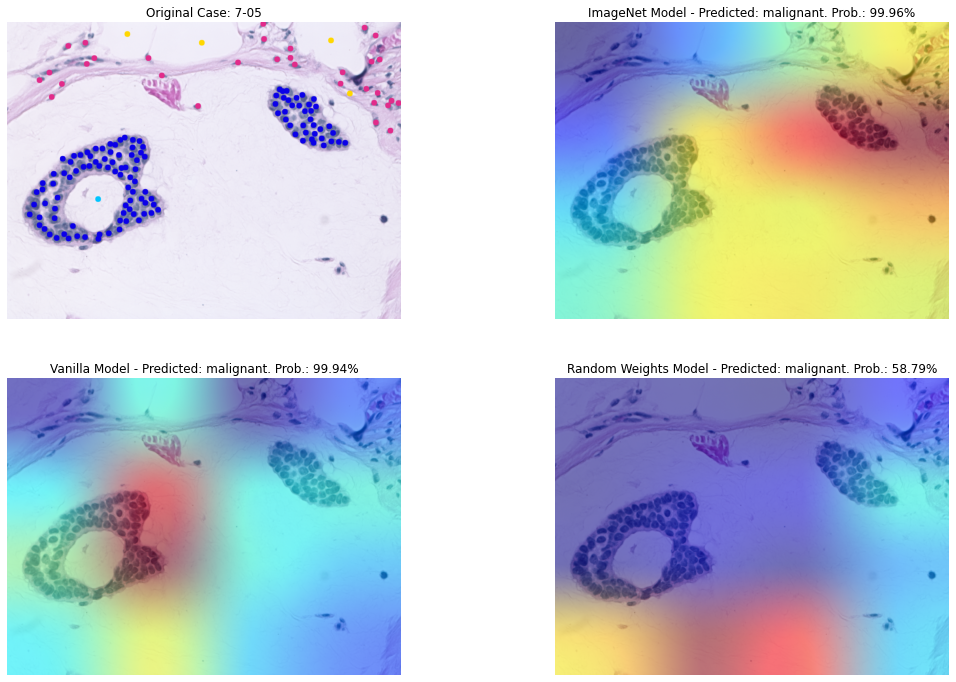

In [30]:
plt.figure(figsize=(18,12))

plt.subplot(2,2,1)
plt.title(f'Original Case: 7-05')
plt.axis(False)
plt.imshow(img1)
plt.subplot(2,2,2)
plt.title(f'ImageNet Model - Predicted: {class_1}. Prob.: {round(probs1*100,2)}%')
plt.axis(False)
result_a = it_test.save_and_display_gradcam(img_path=IMG1, heatmap=heatmap1, pred=class_1)
plt.subplot(2,2,3)
plt.title(f'Vanilla Model - Predicted: {class_2}. Prob.: {round(probs2*100,2)}%')
plt.axis(False)
result_b = it_test.save_and_display_gradcam(img_path=IMG1, heatmap=heatmap2, pred=class_2)
plt.subplot(2,2,4)
plt.title(f'Random Weights Model - Predicted: {class_3}. Prob.: {round(probs3*100,2)}%')
plt.axis(False)
it_test.save_and_display_gradcam(img_path=IMG1, heatmap=heatmap3, pred=class_3);

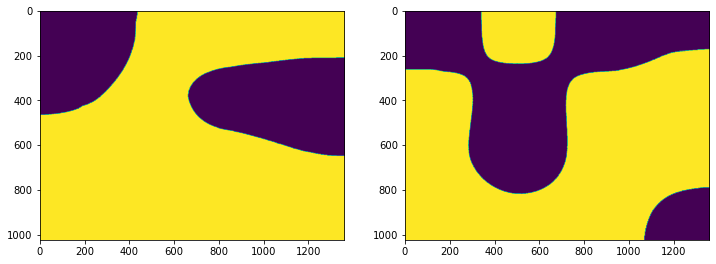

In [31]:
plt.figure(figsize=(12,10))

plt.subplot(1,2,1)
plt.imshow(result_a)
plt.subplot(1,2,2)
plt.imshow(result_b)